In [ ]:
!unzip glove.6B.zip -d my_data


unzip:  cannot find or open glove.6B.zip, glove.6B.zip.zip or glove.6B.zip.ZIP.


In [1]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import keras
from keras.layers import Dense, Embedding, Input, Flatten, LSTM, Conv1D, concatenate, MaxPooling1D
from keras.models import Sequential, Model
from keras_preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB


In [4]:
max_len = 50
embedding_dim = 100

In [59]:
sns.set_theme(style="whitegrid")
df = pd.read_csv("train.csv").sample(frac=1, random_state=42)
test = pd.read_csv("test.csv")

In [60]:
val = df.sample(n=20000)
val, len(val)

(            id    tid1    tid2  \
 207582  121248  136927  136934   
 198623   20634  131402  131396   
 137119  244974   91229   91232   
 105429  184733   70035   70037   
 240635  214348  157826  157916   
 ...        ...     ...     ...   
 94381    57180   63087   63094   
 148064  176252   98199   98200   
 205947  185231  135881  135811   
 63486    83464   43613   94656   
 35852    51759   24454  102340   
 
                                                 title1_en  \
 207582  Li Chen is going to be a father, Fan Bingbing ...   
 198623  Yi Zhong Qixi retired entertainment circle, th...   
 137119  Lin renews love exposure, zhao liying "matchle...   
 105429  Three new subsidies in rural areas, up to fift...   
 240635      The hollow tomatoes are loaded with hormones.   
 ...                                                   ...   
 94381   Yu Ling Xiong said: 2018 will make a lot of po...   
 148064  The delivery boy delivers food in the rain, th...   
 205947          Li 

In [61]:
val['label'].value_counts()

unrelated    13639
agreed        5840
disagreed      521
Name: label, dtype: int64

In [62]:
val.head()

,id,tid1,tid2,title1_en,title2_en,label
207582,121248,136927,136934,"Li Chen is going to be a father, Fan Bingbing ...",Why would Fan Bingbing look at Li Chen? The ba...,unrelated
198623,20634,131402,131396,"Yi Zhong Qixi retired entertainment circle, th...",Yi Zhili has to temporarily retire from the en...,agreed
137119,244974,91229,91232,"Lin renews love exposure, zhao liying ""matchle...","Lin Renxin, Wang Likun love again reality hamm...",unrelated
105429,184733,70035,70037,"Three new subsidies in rural areas, up to fift...",do n't take the cp for her and lin! zhao liyin...,unrelated
240635,214348,157826,157916,The hollow tomatoes are loaded with hormones.,Exposure of Fan Bingbing's Mansion! Li Chen: e...,unrelated


In [63]:
df.drop(columns=['id', 'tid1', 'tid2'], inplace=True)

In [64]:
df.head()

,title1_en,title2_en,label
104355,Homemade rat poison. One dead litter.,"Homemade rat poison, one dead, one dead, all k...",agreed
133170,"By eating these five kinds of vegetables, you ...","Zhang DaDa ""day"" upside down begging for growt...",unrelated
221087,The Shenzhen Nailed Nailed Households Resume $...,Chengdu homebuyers can't buy a house with half...,unrelated
135365,"Wu Jing may face a compensation of 1 billion, ...","With billions of dollars in compensation, Wuji...",agreed
170183,"Yin Xiangjie out of prison, invited Mandar to ...",is xu qing 's current husband a gao bo? the fa...,unrelated


In [65]:
train = df[~df.isin(val)].dropna()

In [66]:
train.head()

,title1_en,title2_en,label
133170,"By eating these five kinds of vegetables, you ...","Zhang DaDa ""day"" upside down begging for growt...",unrelated
221087,The Shenzhen Nailed Nailed Households Resume $...,Chengdu homebuyers can't buy a house with half...,unrelated
135365,"Wu Jing may face a compensation of 1 billion, ...","With billions of dollars in compensation, Wuji...",agreed
170183,"Yin Xiangjie out of prison, invited Mandar to ...",is xu qing 's current husband a gao bo? the fa...,unrelated
213876,Drinking a cup every day after meals can preve...,Drinking one cup a day can prevent and treat h...,agreed


In [67]:
train.label.value_counts(), df.label.value_counts()

(unrelated    161959
 agreed        68398
 disagreed      6085
 Name: label, dtype: int64,
 unrelated    175598
 agreed        74238
 disagreed      6606
 Name: label, dtype: int64)

In [68]:
len(train)

236442

In [69]:
df.head()

,title1_en,title2_en,label
104355,Homemade rat poison. One dead litter.,"Homemade rat poison, one dead, one dead, all k...",agreed
133170,"By eating these five kinds of vegetables, you ...","Zhang DaDa ""day"" upside down begging for growt...",unrelated
221087,The Shenzhen Nailed Nailed Households Resume $...,Chengdu homebuyers can't buy a house with half...,unrelated
135365,"Wu Jing may face a compensation of 1 billion, ...","With billions of dollars in compensation, Wuji...",agreed
170183,"Yin Xiangjie out of prison, invited Mandar to ...",is xu qing 's current husband a gao bo? the fa...,unrelated


In [70]:
test.head()

,id,tid1,tid2,title1_en,title2_en
0,256442,100672,100673,"The great coat brother Zhu Zhu Wen, in the man...","Lin xinsheng after the birth of ""hard milking,..."
1,256443,162269,162270,NASA reveals facts about UFO wreckage found on...,"The UFO found in Yuancun, Jiaocheng County, Sh..."
2,256444,157826,157854,The hollow tomatoes are loaded with hormones.,"Li chenfan bingbing home photos, netizen: this..."
3,256445,109579,74076,Ange Pavilion Geoshui: How accurate is Matrimo...,Master one: the eight-character presumption of...
4,256446,15068,15085,A 50-year-old bus-bus blows up an 8-year-old c...,< i > Joe Johnson's disgruntled timing and ord...


In [71]:
df.isnull().sum(), test.isnull().sum()

(title1_en    0
 title2_en    0
 label        0
 dtype: int64,
 id           0
 tid1         0
 tid2         0
 title1_en    0
 title2_en    0
 dtype: int64)

#### There are no missing values

In [72]:
df['label'].unique()

array(['agreed', 'unrelated', 'disagreed'], dtype=object)

Text(0.5, 0, 'Labels')

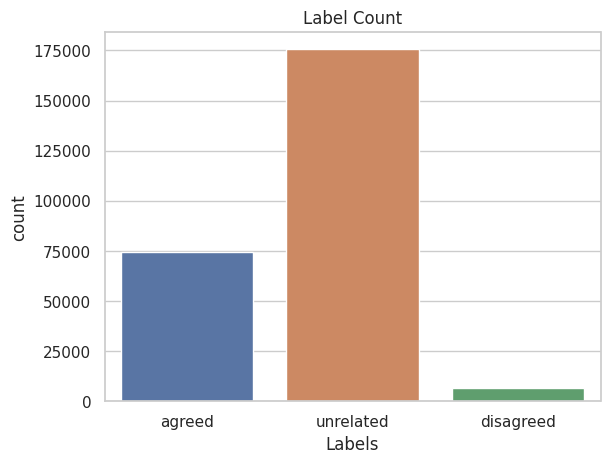

In [73]:
sns.countplot(x=df['label'])
plt.title("Label Count")
plt.xlabel("Labels")

Text(0.5, 0, 'Labels')

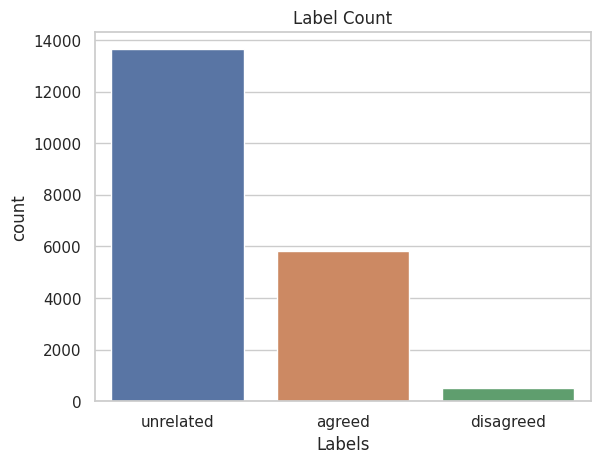

In [74]:
sns.countplot(x=val['label'])
plt.title("Label Count")
plt.xlabel("Labels")

In [75]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [76]:
import nlpaug.augmenter.word as naw
syn_aug = naw.SynonymAug(aug_p=0.3, aug_max=1)

In [77]:
disagreed_train = train[train.label=='disagreed']
curr = []
for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 0]:
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 1])
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence1 = syn_aug.augment(s, n=1)[0]
    mod_sentence2 = syn_aug.augment(disagreed_train.iloc[i, 1], n=1)[0]
    if mod_sentence1 != disagreed_train.iloc[i, 0] and mod_sentence2 != disagreed_train.iloc[i, 1]:
        l.append(mod_sentence1)
        l.append(mod_sentence2)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 1]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 1]:
        l.append(disagreed_train.iloc[i, 0])
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)


In [78]:
len(curr), len(disagreed_train)

(14826, 6085)

In [79]:
syn_aug = naw.SynonymAug(aug_p=0.3, aug_max=3)

In [80]:
for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 0]:
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 1])
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 0]):
    l = []
    mod_sentence1 = syn_aug.augment(s, n=1)[0]
    mod_sentence2 = syn_aug.augment(disagreed_train.iloc[i, 1], n=1)[0]
    if mod_sentence1 != disagreed_train.iloc[i, 0] and mod_sentence2 != disagreed_train.iloc[i, 1]:
        l.append(mod_sentence1)
        l.append(mod_sentence2)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

for i, s in enumerate(disagreed_train.iloc[:, 1]):
    l = []
    mod_sentence = syn_aug.augment(s, n=1)[0]
    if mod_sentence != disagreed_train.iloc[i, 1]:
        l.append(disagreed_train.iloc[i, 0])
        l.append(mod_sentence)
        l.append(disagreed_train.iloc[i, 2])
        curr.append(l)

In [81]:
len(curr)

32710

In [82]:
curr = np.array(curr)

In [83]:
AGREED_COUNT = train['label'].value_counts()[1]
unrelated_train = train[train.label=='unrelated']
agreed_train = train[train.label=='agreed']
disagreed_train = train[train.label=='disagreed']
additional_data = pd.DataFrame(data=curr, columns=['title1_en', 'title2_en', 'label'])
train = pd.concat([unrelated_train, agreed_train, disagreed_train, additional_data], axis=0)

In [84]:
train = train.sample(frac=1, random_state=47)

In [85]:
train.columns

Index(['title1_en', 'title2_en', 'label'], dtype='object')

Text(0.5, 0, 'Labels')

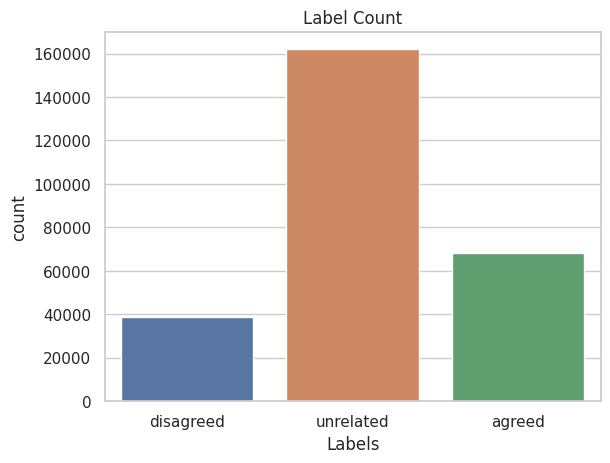

In [86]:
sns.countplot(x=train['label'])
plt.title("Label Count")
plt.xlabel("Labels")

In [87]:
train['label'] = train['label'].map({'unrelated':0, 'agreed':1, 'disagreed':2}).astype(np.uint8)
train.label.unique()

array([2, 0, 1], dtype=uint8)

In [88]:
train['label'].value_counts()

0    161959
1     68398
2     38795
Name: label, dtype: int64

In [89]:
val['label'] = val['label'].map({'unrelated':0, 'agreed':1, 'disagreed':2}).astype(np.uint8)

In [90]:
train.head()

,title1_en,title2_en,label
1040,34 people died in yunnan wenshan flood disaste...,"A netizen in yunnan says ""wenshan flood kills ...",2
80175,Tsao Yan's two -year-old daughter was kidnappe...,Drumline: Li Hongxia's 2 -year-old daughter wa...,0
98288,watching tigers eat people.,Another cctv host cancer recurrence facial def...,0
243014,"Jujube and it together stew soup, poison sex a...",What about goji berries and dates? You wouldn'...,0
167812,"In the cold night, 3-year-old baby looked for ...",Are you still in the baby's crotch? After 3 mo...,0


In [91]:
train['label'].value_counts()

0    161959
1     68398
2     38795
Name: label, dtype: int64

In [92]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [93]:
from transformers import AutoTokenizer

In [94]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
# tokens = tokenizer.encode_plus("hello world", max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')

In [95]:
Xids1 = np.zeros((len(train), max_len))
Xmask1 = np.zeros((len(train), max_len))
Xids2 = np.zeros((len(train), max_len))
Xmask2 = np.zeros((len(train), max_len))

Xids3 = np.zeros((len(val), max_len))
Xmask3 = np.zeros((len(val), max_len))
Xids4 = np.zeros((len(val), max_len))
Xmask4 = np.zeros((len(val), max_len))

In [96]:
for i, sequence in enumerate(train['title1_en']):
  tokens =  tokenizer.encode_plus(sequence, max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
  Xids1[i, :], Xmask1[i,:] = tokens['input_ids'], tokens['attention_mask']


for i, sequence in enumerate(train['title2_en']):
  tokens =  tokenizer.encode_plus(sequence, max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
  Xids2[i, :], Xmask2[i,:] = tokens['input_ids'], tokens['attention_mask']

for i, sequence in enumerate(val['title1_en']):
  tokens =  tokenizer.encode_plus(sequence, max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
  Xids3[i, :], Xmask3[i,:] = tokens['input_ids'], tokens['attention_mask']


for i, sequence in enumerate(val['title2_en']):
  tokens =  tokenizer.encode_plus(sequence, max_length=max_len, truncation=True, padding="max_length", return_token_type_ids=False, return_attention_mask=True, return_tensors='tf')
  Xids4[i, :], Xmask4[i,:] = tokens['input_ids'], tokens['attention_mask']

In [97]:
Xids1

array([[  101.,  3236.,  1234., ...,     0.,     0.,     0.],
       [  101.,   157.,  3202., ...,     0.,     0.,     0.],
       [  101.,  2903., 13778., ...,     0.,     0.,     0.],
       ...,
       [  101.,  1670.,   145., ...,     0.,     0.,     0.],
       [  101.,  1109.,  4639., ...,     0.,     0.,     0.],
       [  101., 15727.,  2021., ...,     0.,     0.,     0.]])

In [98]:
Xmask1

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [99]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [100]:
dataset = tf.data.Dataset.from_tensor_slices((Xids1, Xmask1, Xids2, Xmask2, train['label']))
val_dataset = tf.data.Dataset.from_tensor_slices((Xids3, Xmask3, Xids4, Xmask4, val['label']))

In [101]:
def map_func(input_ids1, masks1, input_ids2, masks2, labels):
  return {'input_ids1':input_ids1, 'masks1': masks1, 'input_ids2': input_ids2, 'masks2':masks2}, labels

In [102]:
dataset = dataset.map(map_func)
val_dataset = val_dataset.map(map_func)

In [103]:
for i in dataset.take(1):
  print(i)

({'input_ids1': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([ 101., 3236., 1234., 1452., 1107.,  194., 3488., 6509., 1195.,
       2316., 3822., 7870., 7286.,  117., 1167., 1190., 1190., 1476.,
        117., 1288., 8754., 1104., 4634., 1298., 1127., 4634.,  119.,
        102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.])>, 'masks1': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>, 'input_ids2': <tf.Tensor: shape=(50,), dtype=float64, numpy=
array([  101.,   138.,  5795.,  3708.,  1179.,  1107.,   194.,  3488.,
        6509.,  1867.,   107.,  1195.,  2316.,  3822.,  7870.,  8567.,
        3236.,  1234.,   107.,  1108., 15474.,  1107.,  32

In [104]:
dataset = dataset.shuffle(1).batch(128)
val_dataset = val_dataset.shuffle(1).batch(128)

In [105]:
DS_LEN = len(list(dataset))
VAL_DS_LEN = len(list(val_dataset))

In [106]:
print(DS_LEN), len(train) // 128

2103


(None, 2102)

In [107]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [108]:
input_shape = (max_len,)
input_ids1 = tf.keras.layers.Input(shape=input_shape, name='input_ids1', dtype='int32')
masks1 = tf.keras.layers.Input(shape=input_shape, name='masks1', dtype='int32')
input_ids2 = tf.keras.layers.Input(shape=input_shape, name='input_ids2', dtype='int32')
masks2 = tf.keras.layers.Input(shape=input_shape, name='masks2', dtype='int32')



In [109]:
embeddings1 = bert(input_ids1, attention_mask=masks1)[0]
embeddings2 = bert(input_ids2, attention_mask=masks2)[0]

In [110]:
conv1 = Conv1D(128, 3, activation='relu')(embeddings1)
conv2 = Conv1D(128, 3, activation='relu')(embeddings2)

pool1 = MaxPooling1D()(conv1)
pool2 = MaxPooling1D()(conv2)

lstm1 = LSTM(64)(pool1)
lstm2 = LSTM(64)(pool2)

x1 = Dense(32)(lstm1)
x2 = Dense(32)(lstm2)

conc = concatenate([x1, x2], axis=-1)
x = Dense(16, activation='relu')(conc)

y = Dense(3, activation='softmax')(x)


model = Model([input_ids1, masks1, input_ids2, masks2], y)
model.layers[4].trainable = False
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids1 (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 masks1 (InputLayer)            [(None, 50)]         0           []                               
                                                                                                  
 input_ids2 (InputLayer)        [(None, 50)]         0           []                               
                                                                                                  
 masks2 (InputLayer)            [(None, 50)]         0           []                               
                                                                                            

In [111]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.Nadam(learning_rate=0.00075), metrics=['accuracy']) 
history = model.fit(dataset, epochs=6, validation_data=val_dataset)

Epoch 1/6
2103/2103 [==============================] - 266s 111ms/step - loss: 0.6013 - accuracy: 0.6975 - val_loss: 0.4932 - val_accuracy: 0.7472
Epoch 2/6
2103/2103 [==============================] - 228s 108ms/step - loss: 0.4836 - accuracy: 0.7596 - val_loss: 0.4529 - val_accuracy: 0.7800
Epoch 3/6
2103/2103 [==============================] - 228s 108ms/step - loss: 0.4205 - accuracy: 0.7959 - val_loss: 0.4387 - val_accuracy: 0.7935
Epoch 4/6
2103/2103 [==============================] - 228s 108ms/step - loss: 0.3795 - accuracy: 0.8205 - val_loss: 0.4378 - val_accuracy: 0.7980
Epoch 5/6
2103/2103 [==============================] - 227s 108ms/step - loss: 0.3510 - accuracy: 0.8363 - val_loss: 0.4329 - val_accuracy: 0.8060
Epoch 6/6
2103/2103 [==============================] - 227s 108ms/step - loss: 0.3289 - accuracy: 0.8490 - val_loss: 0.4270 - val_accuracy: 0.8146


In [112]:
y_pred = model.predict(val_dataset)

157/157 [==============================] - 20s 89ms/step


In [113]:
y_pred = np.argmax(y_pred, axis=1)

In [114]:
from sklearn.metrics import classification_report
print(classification_report(val['label'], y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86     13639
           1       0.72      0.72      0.72      5840
           2       0.54      0.54      0.54       521

    accuracy                           0.81     20000
   macro avg       0.71      0.71      0.71     20000
weighted avg       0.81      0.81      0.81     20000

